# Cleaning-Transformatin-Pipeline for Apex Health 

## Preparation

In [ ]:
# import relevant libraries

# for data cleaning and transformation
import pandas as pd
import numpy as np

# for visualization during eda | quality checks
import matplotlib.pyplot as plt
import seaborn as sns

# for postgresql connection
from sqlalchemy import create_engine
from sqlalchemy.types import String, Integer, BigInteger, Float, Boolean, DateTime

# for bigquery connection
from google.cloud import bigquery
from google.oauth2 import service_account

print('Libraries are loaded')

In [ ]:
# configuration
DB_USER = "postgres"
DB_PASSWORD = "1234"
DB_HOST = "localhost"  # Or your host's IP address/domain
DB_PORT = "5432"
DB_NAME = "postgres"
SCHEMA_NAME = "healthtail"

# create engine
connection_string = (
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    f"?options=-csearch_path%3D{SCHEMA_NAME}"
)
engine = create_engine(connection_string)

# --- Read data from a table into a pandas DataFrame ---
tables = ["orders", "patients", "visits"]
dfs = {} 

for i, table in enumerate(tables):
    try:
        sql_query = f"select * from {table}"
        dfs[table] = pd.read_sql_query(sql_query, engine)
        print(f"Data from table {table} loaded successfully")
        # print(dfs[table].head())
        # print("-" * 50)

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # --- Close the connection ---
        # The 'with' statement or explicit engine.dispose() is recommended for production
        engine.dispose()

Data from table orders loaded successfully
Database connection closed.
Data from table patients loaded successfully
Database connection closed.
Data from table visits loaded successfully
Database connection closed.


## Check for anomalies

### Check missing values

In [25]:
# simple check for empty cells
for key, df in dfs.items():
    print(f'Table {key} contains missing values: ', end='')
    print(df.isna().sum().sum())

Table orders contains missing values: 0
Table patients contains missing values: 0
Table visits contains missing values: 0


In [40]:
# check for '' empty cells

# iterate over dataframes
for name, df in dfs.items():

    # Find the row and column indices of all True values in the mask
    rows, cols = np.where(df == '')
    
    print(f"In table {name} {len(rows)} '' values")

In table orders 0 '' values
In table patients 246 '' values
In table visits 0 '' values


### Check Distributions

In [6]:
# function for displaying histograms and barplots/countplots for respective columns of a dataframe

def plot_numeric_and_categorical(df, exclude:list=None):
    if exclude != None:
        df = df.drop(columns=exclude)
    # Numeric columns
    numeric_cols = df.select_dtypes(include='number')
    numeric_cols = numeric_cols.loc[:, ~numeric_cols.columns.str.contains('id', case=False)].columns
    # Categorical columns (object, category, or bool)
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool'])
    categorical_cols = categorical_cols.loc[:, ~categorical_cols.columns.str.contains('id', case=False)].columns

    # Plot histograms for numeric features
    for col in numeric_cols:
        fig, axes = plt.subplots(1,2,figsize=(8,3))
        axes = axes.flatten()
        sns.histplot(data = df, x=col, kde=True, ax=axes[0])
        axes[0].set_title(f"Histogram of {col}")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Frequency")
        sns.boxplot(data = df, x=col, ax=axes[1])
        axes[1].set_title(f"Boxplot of {col}")
        sns.despine()
        plt.tight_layout()
        plt.show()

    # Plot countplots for categorical features
    for col in categorical_cols:
        plt.figure(figsize=(8,3))
        col_order = df[col].value_counts().sort_values(ascending=False).reset_index().iloc[:,0].to_list()[:10]
        sns.countplot(y=col, data=df, order=col_order)
        plt.title(f"Count Plot of {col} - only top 10")
        plt.xlabel(col)
        plt.ylabel("Count")
        sns.despine()
        plt.tight_layout()
        plt.show()

##### Distribution table Orders

Distibutions for table Orders


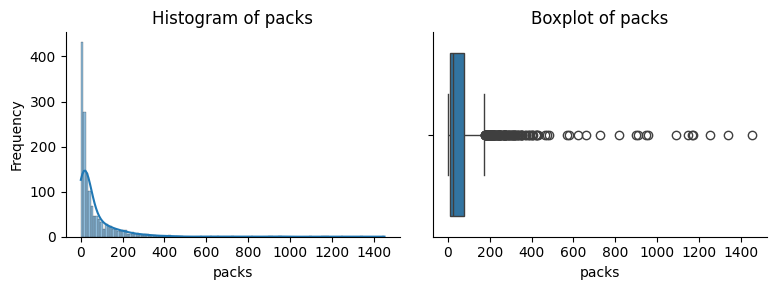

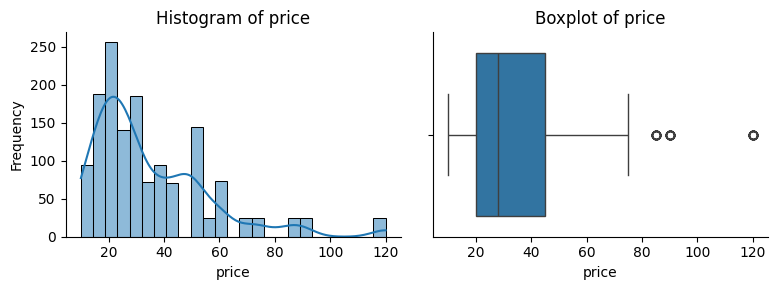

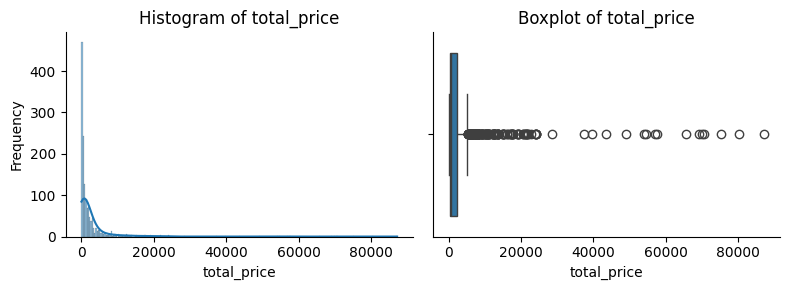

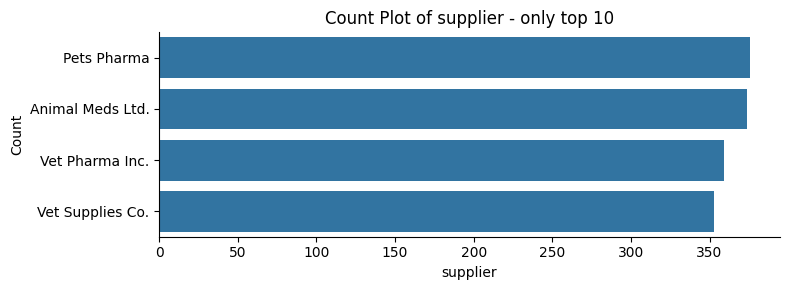

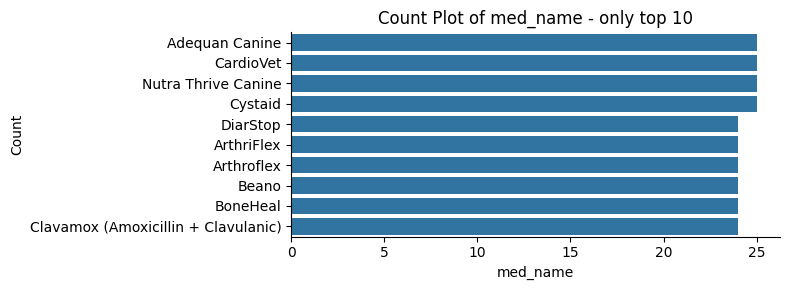

In [7]:
print('Distibutions for table Orders')
plot_numeric_and_categorical(dfs['orders'], exclude=['month_invoice'])

##### Distribution fo table patients

Distibutions for table Orders


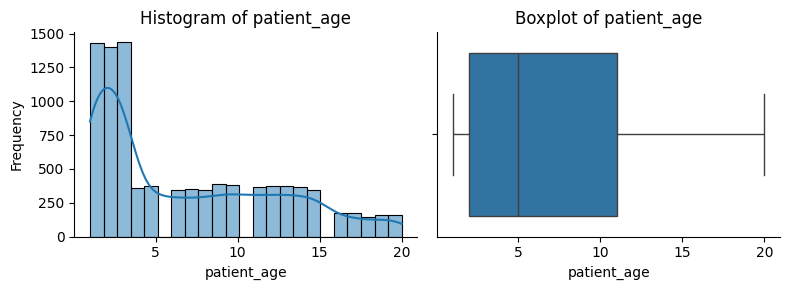

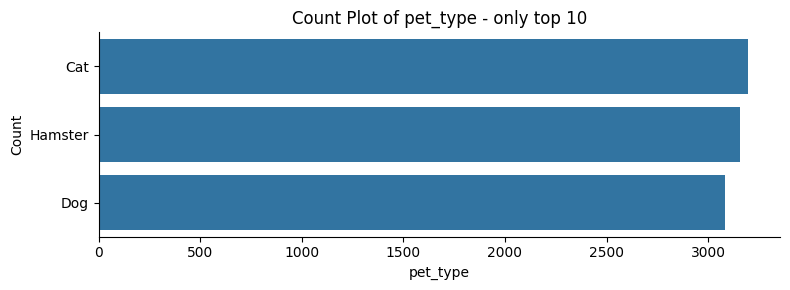

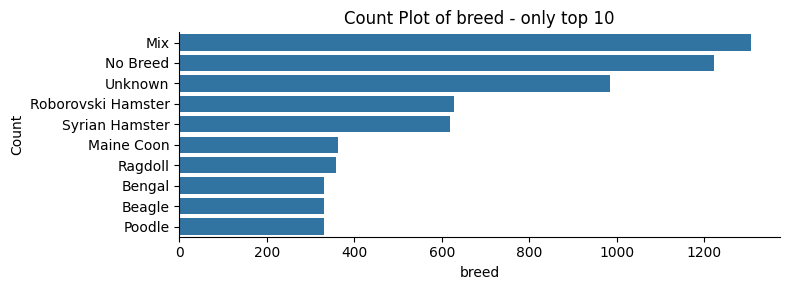

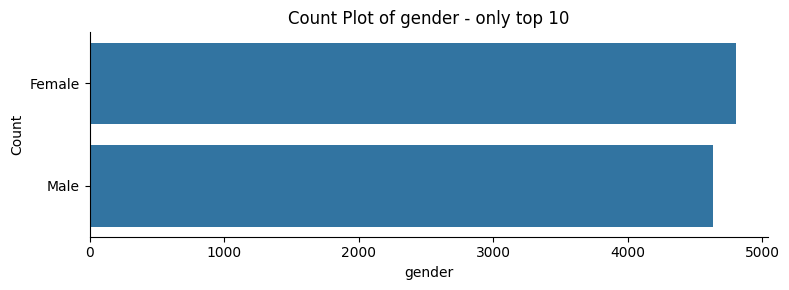

In [8]:
print('Distibutions for table Orders')
plot_numeric_and_categorical(dfs['patients'], exclude=['owner_name','patient_name','date_registration','owner_phone'])

#### Distibution for table visits

Distibutions for table Orders


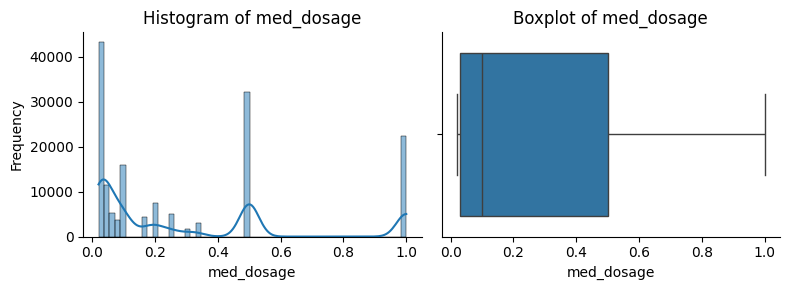

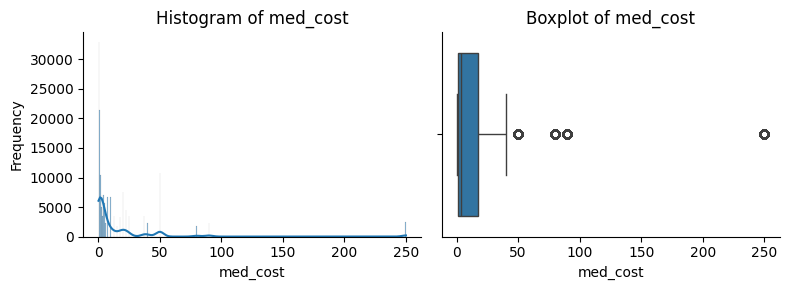

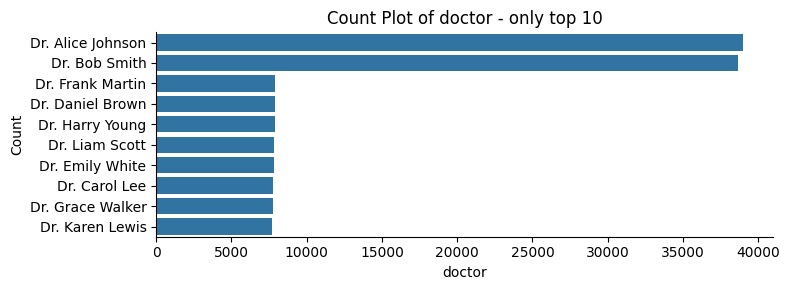

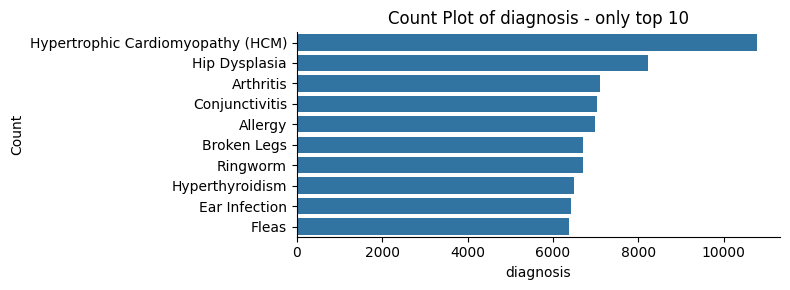

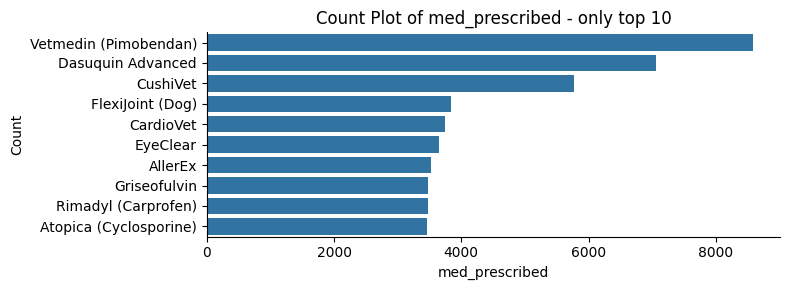

In [9]:
print('Distibutions for table Orders')
plot_numeric_and_categorical(dfs['visits'], exclude=['visit_datetime'])

### Check systematically for 0 or negative values in numerical columns

In [48]:
for name, df in dfs.items():
    numerical_cols = df.select_dtypes('number')
    zero_negative_entries = numerical_cols[numerical_cols<=0].sum().sum()
    print(f'Table {name} has 0 or negative entries in numeric columns: {zero_negative_entries}.')

Table orders has 0 or negative entries in numeric columns: 0.0.
Table patients has 0 or negative entries in numeric columns: 0.0.
Table visits has 0 or negative entries in numeric columns: 0.0.


## Cleaning

### Basic text cleaning

In [10]:
# remove white space, standardise cases, also for following cleaning procedures

# iterate through dataframe and focus on object datatypes - don't overwrite columns but create new columns with ending _cleaned

for name, df in dfs.items():
    print(f'\nCleaning dataframe {name}....')
    cols = list(df.select_dtypes('object').columns)
    for col in cols:
        print(f'Cleaning column {col}.....', end='')
        col_new = f'{col}_clean'
        try:
            dfs[name][col_new] = dfs[name][col].str.strip().str.title()
            print(f'done.')
        except:
            print(f'Column {col} was no datatype string. Not cleaned.')
    print(df.columns)


Cleaning dataframe orders....
Cleaning column month_invoice.....Column month_invoice was no datatype string. Not cleaned.
Cleaning column invoice_id.....done.
Cleaning column supplier.....done.
Cleaning column med_name.....done.
Index(['month_invoice', 'invoice_id', 'supplier', 'med_name', 'packs', 'price',
       'total_price', 'invoice_id_clean', 'supplier_clean', 'med_name_clean'],
      dtype='object')

Cleaning dataframe patients....
Cleaning column patient_id.....done.
Cleaning column owner_name.....done.
Cleaning column pet_type.....done.
Cleaning column breed.....done.
Cleaning column patient_name.....done.
Cleaning column gender.....done.
Cleaning column date_registration.....Column date_registration was no datatype string. Not cleaned.
Cleaning column owner_phone.....done.
Index(['patient_id', 'owner_id', 'owner_name', 'pet_type', 'breed',
       'patient_name', 'gender', 'patient_age', 'date_registration',
       'owner_phone', 'patient_id_clean', 'owner_name_clean', 'pet_t

### Correct datatypes

In [11]:
for key, df in dfs.items():
    display(df.dtypes)

month_invoice        object
invoice_id           object
supplier             object
med_name             object
packs               float64
price               float64
total_price         float64
invoice_id_clean     object
supplier_clean       object
med_name_clean       object
dtype: object

patient_id            object
owner_id               int64
owner_name            object
pet_type              object
breed                 object
patient_name          object
gender                object
patient_age            int64
date_registration     object
owner_phone           object
patient_id_clean      object
owner_name_clean      object
pet_type_clean        object
breed_clean           object
patient_name_clean    object
gender_clean          object
owner_phone_clean     object
dtype: object

visit_id                 object
patient_id               object
visit_datetime           object
doctor                   object
diagnosis                object
med_prescribed           object
med_dosage              float64
med_cost                float64
visit_id_clean           object
patient_id_clean         object
doctor_clean             object
diagnosis_clean          object
med_prescribed_clean     object
dtype: object

In [49]:
# transform datetime columns into correct datatype

dfs['orders']['month_invoice_cleaned'] = pd.to_datetime(dfs['orders']['month_invoice'], errors='coerce')
anzahl_nat = dfs['orders']['month_invoice_cleaned'].isna().sum()
print(f"Nicht konvertierbare Werte (NaT): {anzahl_nat}")

dfs['patients']['date_registration_clean'] = pd.to_datetime(dfs['patients']['date_registration'], errors='coerce')
anzahl_nat = dfs['patients']['date_registration_clean'].isna().sum()
print(f"Nicht konvertierbare Werte (NaT): {anzahl_nat}")

dfs['visits']['visit_datetime_clean'] = pd.to_datetime(dfs['visits']['visit_datetime'], errors='coerce')
anzahl_nat = dfs['visits']['visit_datetime_clean'].isna().sum()
print(f"Nicht konvertierbare Werte (NaT): {anzahl_nat}")

Nicht konvertierbare Werte (NaT): 0
Nicht konvertierbare Werte (NaT): 0
Nicht konvertierbare Werte (NaT): 0


### Phone numbers

There is phone numbers with + and spaces and more. Typos from the frontdesk. Clean automatically as much as possib.e

In [13]:
dfs['patients']['owner_phone']

0        +44 7700 421511
1        +44 7686 703051
2       +44 75(97 996856
3        +44 7597 996856
4        +44 7700 421511
              ...       
9430     +44 7050 526644
9431     +44 7330 843657
9432     +44 7353 299907
9433     +44 7504 884194
9434     +44 7937 588132
Name: owner_phone, Length: 9435, dtype: object

In [14]:
import re

def clean_phone_numbers(df):
    """
    Cleans phone numbers in a specified DataFrame column.

    Steps:
    1. Replaces a leading '+' with '00' for international format.
    2. Removes all non-digit characters (including spaces, hyphens, parentheses, etc.).

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column containing phone numbers.

    Returns:
        pd.DataFrame: A new DataFrame with the cleaned phone numbers.
    """
    # check datatype object/text
    if df.dtype != 'object': 
        print('Wrong input. Expect dataframe and column_name as string')
    
    # Make a copy to avoid modifying the original DataFrame
    cleaned_df = df.copy()
    
    # Clean from leading / tailing white space
    cleaned_df = cleaned_df.str.strip()

    # Replace leading '+' with '00'
    cleaned_df = cleaned_df.apply(
        lambda x: '00' + x[1:] if x.startswith('+') else x
    )

    # Remove all non-digit characters and whitespaces, tabs etc
    cleaned_df = cleaned_df.str.replace(r'\D', '', regex=True)

    return cleaned_df

In [15]:
dfs['patients']['owner_phone_clean'] = clean_phone_numbers(dfs['patients']['owner_phone'])

### Cleaning animal breed

Frontdesk has sometimes called it unknown or none. Clean this

In [16]:
replace_dict = {
    'no breed' : 'unknown',
    '': 'unknown'
}

dfs['patients']['breed_clean'] = dfs['patients']['breed'].str.strip().str.lower().replace(replace_dict).str.capitalize()

### Check for outliers dates

In [64]:
# Use a dedicated NumPy function to get the string representation
#dt_string = np.datetime_as_string(dt_object)
#print(dt_string)

for name, df in dfs.items():
    datetime_cols = df.select_dtypes('datetime')
    date_start, date_end = np.datetime_as_string(datetime_cols.min()), np.datetime_as_string(datetime_cols.max())
    print(f'In table {name} dates begin at {date_start} and end with {date_end}')

In table orders dates begin at ['2024-01-01T00:00:00.000000000'] and end with ['2026-01-01T00:00:00.000000000']
In table patients dates begin at ['2024-01-01T00:00:00.000000000'] and end with ['2024-12-31T00:00:00.000000000']
In table visits dates begin at ['2024-01-03T00:00:00.000000000'] and end with ['2026-01-05T00:00:00.000000000']


*Note*: Future values are OK in this time because the setup of our project states we are in the future ;-)

## EDA for time-series

Can be removed for production code

In [17]:
# Create dictionary containing info for tables and columns which shall be plotted

chart_dict = {
    'visits':'visit_datetime_clean',
    'orders':'month_invoice_cleaned',
    'patients':'date_registration_clean'
}

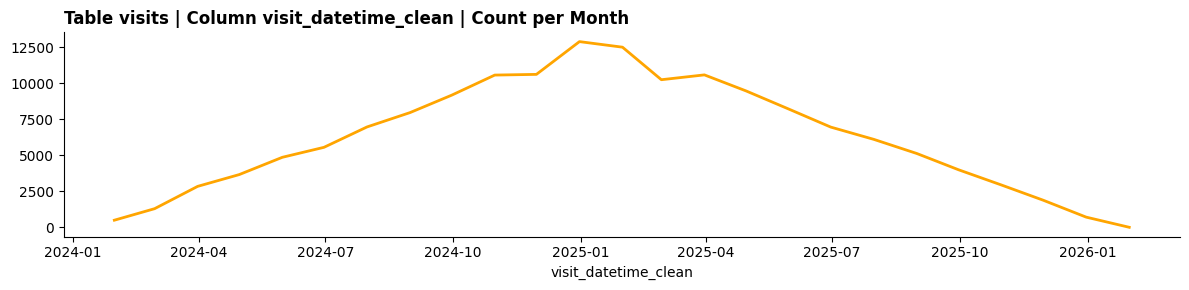

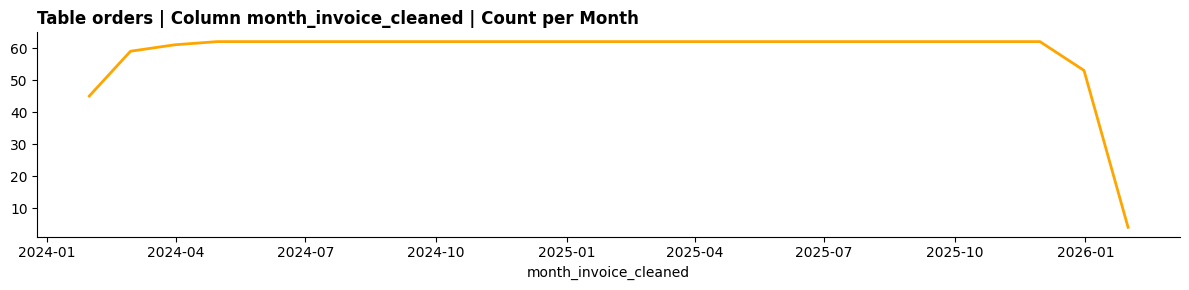

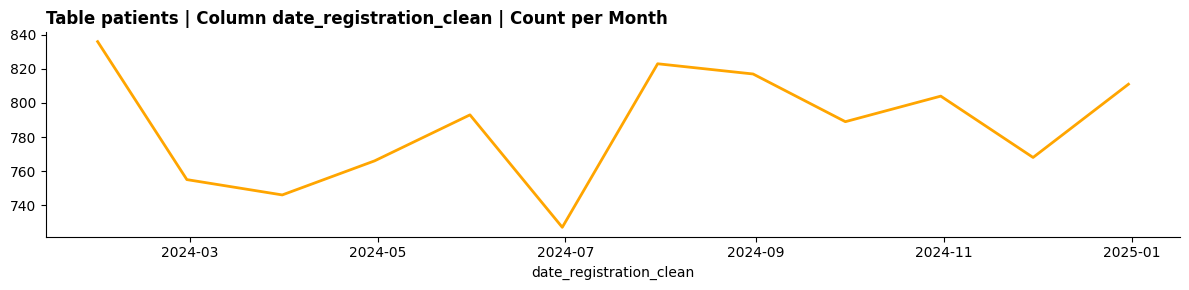

In [18]:
# plot previously defined tables and columns

for table, column in chart_dict.items():
    
    # aggregate daily data to monthly data
    monthly_data = dfs[table].set_index(column).resample('ME').size()
    
    # plot the data
    plt.figure(figsize=(12,3))
    sns.lineplot(data=monthly_data, linewidth=2, color='orange')
    
    # title and clean up
    plt.title(f'Table {table} | Column {column} | Count per Month', loc='left', fontweight='bold')
    sns.despine()
    plt.tight_layout()
    plt.show()

## Finalize cleaned tables

In [19]:
# drop already cleaned columns and clean columns names

# define columns which can be dropped
drop_cols = {
    'orders': ['month_invoice', 'invoice_id', 'supplier', 'med_name'], 
    'patients': ['patient_id', 'owner_name', 'pet_type', 'breed', 'patient_name', 'gender', 'date_registration', 'owner_phone'],
    'visits': ['visit_id', 'patient_id', 'visit_datetime', 'doctor', 'diagnosis', 'med_prescribed']
}

# make safe copy
dfs_copy = dfs.copy()

# drop defined columns  
for key, value in drop_cols.items():
    try:
        dfs[key] = dfs[key].drop(columns=value)
    except: pass
    finally: print(dfs[key].columns)
    
# clean up names of cleaned columns by removing _clean
for key, df in dfs.items():
    col_names = list(df.columns)
    col_names_cleaned = [x.replace('_clean','').strip().lower() for x in col_names]
    dfs[key].columns = col_names_cleaned

print('Tables are cleaned and ready for upload.')

Index(['packs', 'price', 'total_price', 'invoice_id_clean', 'supplier_clean',
       'med_name_clean', 'month_invoice_cleaned'],
      dtype='object')
Index(['owner_id', 'patient_age', 'patient_id_clean', 'owner_name_clean',
       'pet_type_clean', 'breed_clean', 'patient_name_clean', 'gender_clean',
       'owner_phone_clean', 'date_registration_clean'],
      dtype='object')
Index(['med_dosage', 'med_cost', 'visit_id_clean', 'patient_id_clean',
       'doctor_clean', 'diagnosis_clean', 'med_prescribed_clean',
       'visit_datetime_clean'],
      dtype='object')
Tables are cleaned and ready for upload.


# Return to PostgreSQL

In [65]:
# configuration
DB_USER = "postgres"
DB_PASSWORD = "1234"
DB_HOST = "localhost"  # Or your host's IP address/domain
DB_PORT = "5432"
DB_NAME = "postgres"
SCHEMA_NAME = "healthtail"

# create engine
connection_string = (
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    f"?options=-csearch_path%3D{SCHEMA_NAME}"
)
engine = create_engine(connection_string)

# define tables names
tables_names = {
    'orders':'orders_clean',
    'visits':'visits_clean',
    'patients':'patients_clean'
}

# function to derive datatypes for postgresql from pandas dataframe
def get_sqlalchemy_dtype(pandas_dtype):
    if pd.api.types.is_integer_dtype(pandas_dtype):
        return Integer  
    if pd.api.types.is_float_dtype(pandas_dtype):
        return Float
    if pd.api.types.is_string_dtype(pandas_dtype):
        return String(255) 
    if pd.api.types.is_bool_dtype(pandas_dtype):
        return Boolean
    if pd.api.types.is_datetime64_any_dtype(pandas_dtype):
        return DateTime
    # fallback for not detected datatypes
    return String(255)

# automatic mapping and ingest data into postgreSQL

for name_old, name_new in tables_names.items():

    # mapping
    dtype_mapping = {
        col: get_sqlalchemy_dtype(dfs[name_old][col].dtype) for col in dfs[name_old].columns
    }
    print(f'Writing table {name_old} with mapping: {dtype_mapping}......')
    
    # ingest
    try:
        dfs[name_old].to_sql(
            name_new,
            engine,
            schema=SCHEMA_NAME,
            if_exists='replace',
            index=False,
            dtype=dtype_mapping  # Das dynamisch erstellte Mapping verwenden
        )
        print(f"Dataframe successfully written as'{SCHEMA_NAME}.{name_new}'.\n")
    except Exception as e:
        print(f"Error thrwown: {e}")
        
    finally:
        # Close connection
        engine.dispose()

Writing table orders with mapping: {'month_invoice': String(length=255), 'invoice_id': String(length=255), 'supplier': String(length=255), 'med_name': String(length=255), 'packs': <class 'sqlalchemy.sql.sqltypes.Float'>, 'price': <class 'sqlalchemy.sql.sqltypes.Float'>, 'total_price': <class 'sqlalchemy.sql.sqltypes.Float'>, 'month_invoice_cleaned': <class 'sqlalchemy.sql.sqltypes.DateTime'>}......
Dataframe successfully written as'healthtail.orders_clean'.

Writing table visits with mapping: {'visit_id': String(length=255), 'patient_id': String(length=255), 'visit_datetime': String(length=255), 'doctor': String(length=255), 'diagnosis': String(length=255), 'med_prescribed': String(length=255), 'med_dosage': <class 'sqlalchemy.sql.sqltypes.Float'>, 'med_cost': <class 'sqlalchemy.sql.sqltypes.Float'>, 'visit_datetime_clean': <class 'sqlalchemy.sql.sqltypes.DateTime'>}......
Dataframe successfully written as'healthtail.visits_clean'.

Writing table patients with mapping: {'patient_id': S

# Ingest into BigQuery

**Required libraries**

%pip install google-cloud-bigquery google-auth<br>
%pip install google-cloud-bigquery[pandas]<br>
%pip install pandas<br>
%pip install db-dtypes<br>
%pip install pyarrow<br>

**Further requirements**

Service account with appropriate rights (editor) and json-key file with credentials 

In [66]:
# define project_id, dataset and get credentials
dataset_id = "masteschool-gcp.apex_integration"
credentials_path = r'masteschool-gcp-SA-cleaning.json'
credentials = service_account.Credentials.from_service_account_file(credentials_path)

# Create a big query client pointing at project
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Create new dataset if required
dataset = bigquery.Dataset(dataset_id)
dataset.location = "EU" 
client.create_dataset(dataset, exists_ok=True)

# for each dataframe in dict set target table and write dataframe to bigquery
for table, df in dfs.items():
    print('Writing {table} to bigquery dataset{dataset_id}.')
    table_id = f'{dataset_id}.{table}_clean'  
    job = client.load_table_from_dataframe(df, table_id, job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE"))
    job.result()
    print('Successfully written as table {table}_clean.\n')
    

Writing {table} to bigquery dataset{dataset_id}.
Successfully written as table {table}_clean.

Writing {table} to bigquery dataset{dataset_id}.
Successfully written as table {table}_clean.

Writing {table} to bigquery dataset{dataset_id}.
Successfully written as table {table}_clean.

